# Affinify Data Analysis Dashboard 🧬

**AI-Powered Protein-Ligand Binding Affinity Prediction Analysis**

This notebook provides comprehensive analysis and visualization of the Affinify project data, including:
- Dataset overview and statistics
- Binding affinity distributions
- Feature analysis and importance
- Model performance comparison
- Molecular property exploration

---

**Author:** Pranav Verma  
**School:** Lotus Valley International School  

In [3]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import warnings
from pathlib import Path
import sys
import os

# Add project root to path
sys.path.append(os.path.join(os.getcwd(), '..'))

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set up paths
PROJECT_ROOT = Path('../')
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
RESULTS_DIR = PROJECT_ROOT / 'results'
MODELS_DIR = PROJECT_ROOT / 'models'

print("🧬 Affinify Data Analysis Setup Complete!")
print(f"📂 Data directory: {DATA_DIR}")
print(f"📊 Results directory: {RESULTS_DIR}")
print(f"🤖 Models directory: {MODELS_DIR}")

🧬 Affinify Data Analysis Setup Complete!
📂 Data directory: ../data/processed
📊 Results directory: ../results
🤖 Models directory: ../models


## 1. Data Loading and Overview 📊

Let's start by loading all the available data files and understanding the structure of our dataset.

In [4]:
# Load all available data
data_files = {}
data_summary = {}

# Check for data files
for file_pattern in ['*.csv', '*.json']:
    for file_path in DATA_DIR.glob(file_pattern):
        try:
            if file_path.suffix == '.csv':
                df = pd.read_csv(file_path)
                data_files[file_path.stem] = df
                data_summary[file_path.stem] = {
                    'type': 'CSV',
                    'shape': df.shape,
                    'columns': list(df.columns),
                    'memory_usage': f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
                }
            elif file_path.suffix == '.json':
                with open(file_path, 'r') as f:
                    json_data = json.load(f)
                data_files[file_path.stem] = json_data
                data_summary[file_path.stem] = {
                    'type': 'JSON',
                    'keys': list(json_data.keys()) if isinstance(json_data, dict) else None
                }
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

print("📂 Available Data Files:")
print("=" * 50)
for name, summary in data_summary.items():
    print(f"📄 {name}:")
    for key, value in summary.items():
        print(f"   {key}: {value}")
    print()

# Quick overview of main datasets
if 'processed_features' in data_files:
    features_df = data_files['processed_features']
    print(f"✅ Features Dataset: {features_df.shape[0]} samples, {features_df.shape[1]} features")
    
if 'target_values' in data_files:
    target_df = data_files['target_values']
    print(f"✅ Target Dataset: {len(target_df)} values")
    
if 'bindingdb_subset' in data_files:
    bindingdb_df = data_files['bindingdb_subset']
    print(f"✅ BindingDB Subset: {bindingdb_df.shape[0]} records")

print("\n🎯 Data loading complete!")

📂 Available Data Files:
📄 bindingdb_subset:
   type: CSV
   shape: (50000, 6)
   columns: ['Ligand SMILES', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'Target Name']
   memory_usage: 11.11 MB

📄 processed_features:
   type: CSV
   shape: (42395, 32)
   columns: ['mol_weight', 'smiles_length', 'carbon_count', 'nitrogen_count', 'oxygen_count', 'sulfur_count', 'halogen_count', 'single_bonds', 'double_bonds', 'triple_bonds', 'aromatic_bonds', 'num_rings', 'aromatic_atoms', 'aliphatic_rings', 'hydroxyl_groups', 'carbonyl_groups', 'carboxyl_groups', 'amino_groups', 'methyl_groups', 'phenyl_groups', 'branch_points', 'complexity_score', 'hetero_ratio', 'positive_charges', 'negative_charges', 'chiral_centers', 'cis_trans_bonds', 'mw_per_atom', 'heavy_atom_ratio', 'ring_density', 'saturation_ratio', 'flexibility_score']
   memory_usage: 10.35 MB

📄 bindingdb_features:
   type: CSV
   shape: (42395, 32)
   columns: ['mol_weight', 'smiles_length', 'carbon_count', 'nitrogen_count', 'oxygen_cou

## 2. Binding Affinity Distribution Analysis 🎯

Understanding the distribution of binding affinity values is crucial for model performance.

In [5]:
# Analyze binding affinity distributions
if 'bindingdb_subset' in data_files:
    df = data_files['bindingdb_subset']
    
    # Get all affinity columns
    affinity_cols = ['Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)']
    existing_cols = [col for col in affinity_cols if col in df.columns]
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Raw Binding Values (nM)', 'Log10 Transformed', 
                       'p-Scale (9-log10)', 'Data Availability'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"type": "bar"}]]
    )
    
    # Collect all valid values for analysis
    all_values = []
    col_counts = {}
    
    for col in existing_cols:
        values = df[col].dropna()
        values = values[(values > 0) & (values < 1000000)]  # Filter reasonable range
        all_values.extend(values.tolist())
        col_counts[col] = len(values)
    
    if all_values:
        all_values = np.array(all_values)
        
        # Raw values histogram
        fig.add_trace(
            go.Histogram(x=all_values, nbinsx=50, name="Raw Values (nM)", 
                        opacity=0.7, marker_color='blue'),
            row=1, col=1
        )
        
        # Log10 transformed
        log_values = np.log10(all_values)
        fig.add_trace(
            go.Histogram(x=log_values, nbinsx=50, name="Log10 Values", 
                        opacity=0.7, marker_color='green'),
            row=1, col=2
        )
        
        # p-scale (correct transformation)
        p_values = 9 - log_values
        fig.add_trace(
            go.Histogram(x=p_values, nbinsx=50, name="p-Scale", 
                        opacity=0.7, marker_color='red'),
            row=2, col=1
        )
        
        # Data availability bar chart
        fig.add_trace(
            go.Bar(x=list(col_counts.keys()), y=list(col_counts.values()), 
                  name="Data Count", marker_color='orange'),
            row=2, col=2
        )
        
        # Update layout
        fig.update_layout(
            height=800,
            title_text="🎯 Binding Affinity Distribution Analysis",
            showlegend=True
        )
        
        # Update axes labels
        fig.update_xaxes(title_text="Binding Affinity (nM)", row=1, col=1)
        fig.update_xaxes(title_text="Log10(Binding Affinity)", row=1, col=2)
        fig.update_xaxes(title_text="p-Scale Value", row=2, col=1)
        fig.update_xaxes(title_text="Affinity Type", row=2, col=2)
        
        fig.update_yaxes(title_text="Frequency", row=1, col=1)
        fig.update_yaxes(title_text="Frequency", row=1, col=2)
        fig.update_yaxes(title_text="Frequency", row=2, col=1)
        fig.update_yaxes(title_text="Count", row=2, col=2)
        
        fig.show()
        
        # Print statistics
        print("📊 Binding Affinity Statistics:")
        print("=" * 40)
        print(f"Total samples: {len(all_values):,}")
        print(f"Raw range: {all_values.min():.1f} - {all_values.max():.1f} nM")
        print(f"Log10 range: {log_values.min():.2f} - {log_values.max():.2f}")
        print(f"p-Scale range: {p_values.min():.2f} - {p_values.max():.2f}")
        print(f"Median binding affinity: {np.median(all_values):.1f} nM")
        print(f"Mean p-Scale: {np.mean(p_values):.2f}")
        
else:
    print("❌ No BindingDB data available for analysis")

📊 Binding Affinity Statistics:
Total samples: 44,455
Raw range: 0.0 - 954000.0 nM
Log10 range: -5.22 - 5.98
p-Scale range: 3.02 - 14.22
Median binding affinity: 260.0 nM
Mean p-Scale: 6.60


## 3. Molecular Features Analysis 🧪

Exploring the molecular descriptors used for binding affinity prediction.

🧪 Molecular Features Overview:
Total features: 32
Total samples: 42395
Feature categories: 32 descriptors


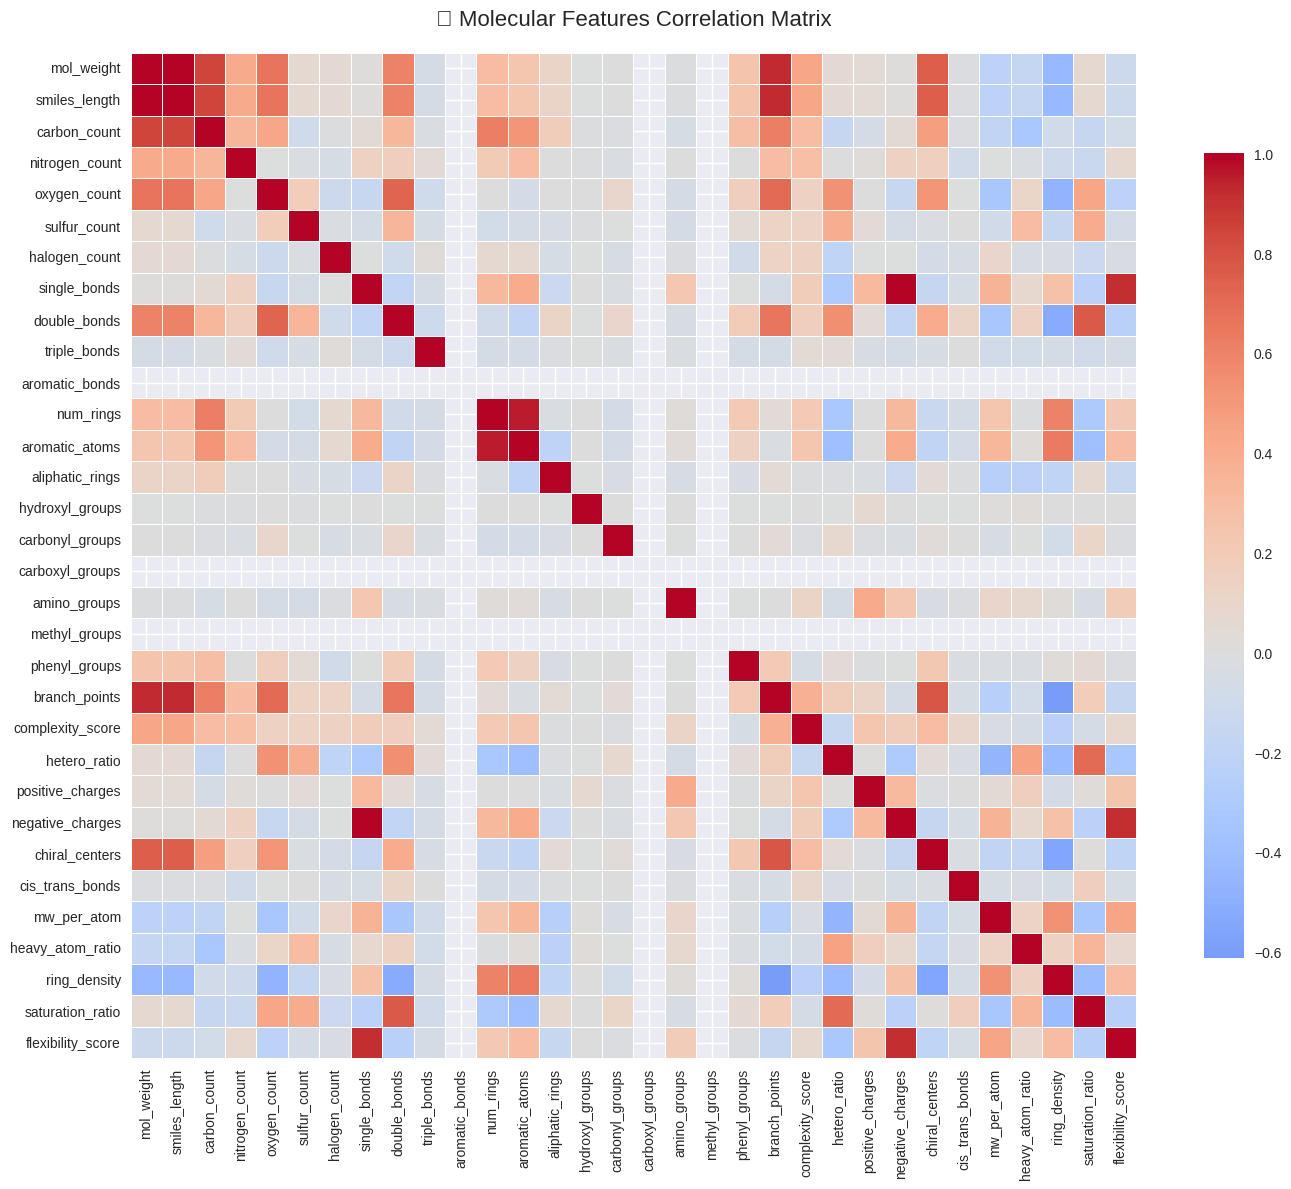

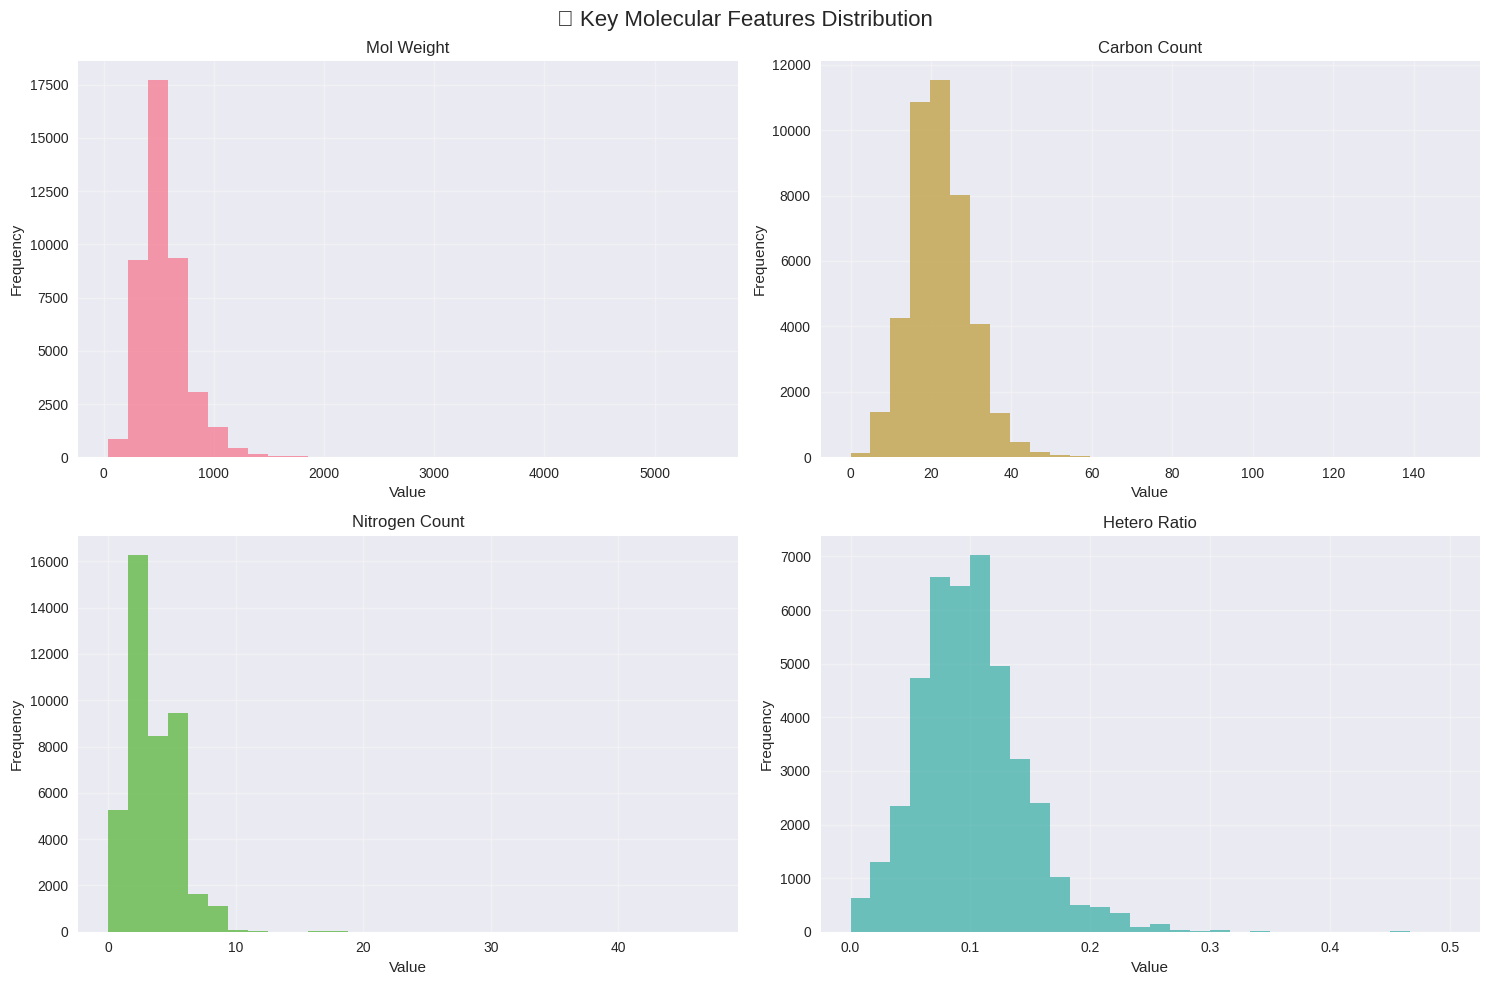


📊 Model Performance Summary:

📈 Feature Statistics Summary:
       mol_weight  smiles_length  carbon_count  nitrogen_count  oxygen_count  \
count   42395.000      42395.000     42395.000       42395.000     42395.000   
mean      548.666         54.867        22.015           3.586         3.149   
std       216.794         21.679         7.520           2.000         2.284   
min        40.000          4.000         0.000           0.000         0.000   
25%       410.000         41.000        17.000           2.000         2.000   
50%       520.000         52.000        22.000           3.000         3.000   
75%       640.000         64.000        27.000           5.000         4.000   
max      5480.000        548.000       149.000          47.000        42.000   

       sulfur_count  halogen_count  single_bonds  double_bonds  triple_bonds  \
count     42395.000      42395.000     42395.000     42395.000     42395.000   
mean          0.439          0.794         0.409         2

In [6]:
# Analyze molecular features
if 'processed_features' in data_files:
    features_df = data_files['processed_features']
    
    # Feature statistics
    print("🧪 Molecular Features Overview:")
    print("=" * 40)
    print(f"Total features: {len(features_df.columns)}")
    print(f"Total samples: {len(features_df)}")
    print(f"Feature categories: {len(features_df.columns)} descriptors")
    
    # Create feature correlation heatmap
    plt.figure(figsize=(15, 12))
    correlation_matrix = features_df.corr()
    
    # Plot heatmap
    sns.heatmap(correlation_matrix, 
                annot=False,  # Too many features for annotations
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8})
    
    plt.title('🧪 Molecular Features Correlation Matrix', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Feature distribution analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    # Select representative features for visualization
    key_features = ['mol_weight', 'carbon_count', 'nitrogen_count', 'hetero_ratio']
    available_features = [feat for feat in key_features if feat in features_df.columns]
    
    for i, feature in enumerate(available_features[:4]):
        ax = axes[i]
        features_df[feature].hist(bins=30, alpha=0.7, ax=ax, color=f'C{i}')
        ax.set_title(f'{feature.replace("_", " ").title()}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('🧪 Key Molecular Features Distribution', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Feature importance (if available from model results)
    if RESULTS_DIR.exists():
        try:
            # Check for enhanced metrics
            enhanced_metrics_file = RESULTS_DIR / 'enhanced_metrics.json'
            model_metrics_file = RESULTS_DIR / 'model_metrics.json'
            
            metrics_file = enhanced_metrics_file if enhanced_metrics_file.exists() else model_metrics_file
            
            if metrics_file.exists():
                with open(metrics_file, 'r') as f:
                    metrics = json.load(f)
                
                print("\n📊 Model Performance Summary:")
                print("=" * 40)
                for model_name, model_data in metrics.items():
                    if 'r2_score' in model_data:
                        r2 = model_data['r2_score']
                        rmse = model_data.get('rmse', 'N/A')
                        print(f"{model_name}: R² = {r2:.4f}, RMSE = {rmse}")
                        
        except Exception as e:
            print(f"Could not load model results: {e}")
    
    # Basic feature statistics table
    feature_stats = features_df.describe().round(3)
    print("\n📈 Feature Statistics Summary:")
    print("=" * 50)
    print(feature_stats.head(10))  # Show first 10 features
    
else:
    print("❌ No processed features data available for analysis")

## 4. Model Performance Analysis 🤖

Comprehensive analysis of machine learning model performance and comparison.

In [ ]:
# Model performance analysis
model_results = {}

# Load model metrics
if RESULTS_DIR.exists():
    for metrics_file in RESULTS_DIR.glob('*metrics.json'):
        try:
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)
            model_results[metrics_file.stem] = metrics
        except Exception as e:
            print(f"Error loading {metrics_file}: {e}")

if model_results:
    print("🤖 Model Performance Analysis:")
    print("=" * 40)
    
    # Create comparison visualization
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('R² Score Comparison', 'RMSE Comparison', 
                       'Model Evolution', 'Performance Metrics'),
        specs=[[{"type": "bar"}, {"type": "bar"}],
               [{"type": "scatter"}, {"type": "table"}]]
    )
    
    # Collect metrics for visualization
    all_models = []
    r2_scores = []
    rmse_scores = []
    
    for result_type, metrics in model_results.items():
        for model_name, model_data in metrics.items():
            if isinstance(model_data, dict) and 'r2_score' in model_data:
                all_models.append(f"{model_name} ({result_type})")
                r2_scores.append(model_data['r2_score'])
                rmse_scores.append(model_data.get('rmse', 0))
    
    # R² Score comparison
    fig.add_trace(
        go.Bar(x=all_models, y=r2_scores, name="R² Score", 
               marker_color='lightblue'),
        row=1, col=1
    )
    
    # RMSE comparison
    fig.add_trace(
        go.Bar(x=all_models, y=rmse_scores, name="RMSE", 
               marker_color='lightcoral'),
        row=1, col=2
    )
    
    # Model evolution (if we have multiple versions)
    if len(all_models) > 1:
        fig.add_trace(
            go.Scatter(x=list(range(len(all_models))), y=r2_scores, 
                      mode='lines+markers', name="R² Evolution",
                      line=dict(color='green', width=3)),
            row=2, col=1
        )
    
    # Performance metrics table
    table_data = []
    for i, model in enumerate(all_models):
        table_data.append([model, f"{r2_scores[i]:.4f}", f"{rmse_scores[i]:.4f}"])
    
    fig.add_trace(
        go.Table(
            header=dict(values=['Model', 'R² Score', 'RMSE'],
                       fill_color='lightblue',
                       align='left'),
            cells=dict(values=list(zip(*table_data)),
                      fill_color='lightgray',
                      align='left')
        ),
        row=2, col=2
    )
    
    fig.update_layout(
        height=800,
        title_text="🤖 Model Performance Dashboard",
        showlegend=True
    )
    
    fig.update_xaxes(title_text="Models", row=1, col=1)
    fig.update_xaxes(title_text="Models", row=1, col=2)
    fig.update_xaxes(title_text="Training Iteration", row=2, col=1)
    
    fig.update_yaxes(title_text="R² Score", row=1, col=1)
    fig.update_yaxes(title_text="RMSE", row=1, col=2)
    fig.update_yaxes(title_text="R² Score", row=2, col=1)
    
    fig.show()
    
    # Best model analysis
    if r2_scores:
        best_idx = np.argmax(r2_scores)
        best_model = all_models[best_idx]
        best_r2 = r2_scores[best_idx]
        best_rmse = rmse_scores[best_idx]
        
        print(f"\n🏆 Best Performing Model:")
        print(f"Model: {best_model}")
        print(f"R² Score: {best_r2:.4f}")
        print(f"RMSE: {best_rmse:.4f}")
        
        # Performance interpretation
        if best_r2 > 0.8:
            performance = "Excellent"
        elif best_r2 > 0.6:
            performance = "Good"
        elif best_r2 > 0.4:
            performance = "Moderate"
        else:
            performance = "Poor"
        
        print(f"Performance Rating: {performance}")
        print(f"Variance Explained: {best_r2*100:.1f}%")

else:
    print("❌ No model results available for analysis")
    print("Run model training first: python scripts/affinity_cli.py --train")

## 5. SMILES and Chemical Space Analysis 🧪

Exploring the chemical space and molecular diversity in our dataset.

In [8]:
# SMILES and Chemical Space Analysis
if 'bindingdb_subset' in data_files:
    df = data_files['bindingdb_subset']
    
    if 'Ligand SMILES' in df.columns:
        smiles_data = df['Ligand SMILES'].dropna()
        
        print("🧪 Chemical Space Analysis:")
        print("=" * 40)
        print(f"Total compounds: {len(smiles_data)}")
        print(f"Unique compounds: {len(smiles_data.unique())}")
        print(f"Duplicate ratio: {(1 - len(smiles_data.unique())/len(smiles_data))*100:.1f}%")
        
        # SMILES length analysis
        smiles_lengths = smiles_data.str.len()
        
        # Create visualization for chemical space
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('SMILES Length Distribution', 'Atom Count Distribution',
                           'Chemical Diversity', 'Common Functional Groups'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"type": "bar"}]]
        )
        
        # SMILES length distribution
        fig.add_trace(
            go.Histogram(x=smiles_lengths, nbinsx=40, name="SMILES Length", 
                        opacity=0.7, marker_color='purple'),
            row=1, col=1
        )
        
        # Atom count estimation (rough)
        atom_counts = smiles_data.apply(lambda x: x.count('C') + x.count('N') + x.count('O') + x.count('S'))
        
        fig.add_trace(
            go.Histogram(x=atom_counts, nbinsx=40, name="Atom Count", 
                        opacity=0.7, marker_color='teal'),
            row=1, col=2
        )
        
        # Chemical diversity (unique character count)
        diversity_scores = smiles_data.apply(lambda x: len(set(x)))
        
        fig.add_trace(
            go.Histogram(x=diversity_scores, nbinsx=30, name="Diversity Score", 
                        opacity=0.7, marker_color='orange'),
            row=2, col=1
        )
        
        # Common functional groups
        functional_groups = {
            'Aromatic': smiles_data.str.count('c').sum(),
            'Hydroxyl': smiles_data.str.count('O').sum(),
            'Amino': smiles_data.str.count('N').sum(),
            'Carbonyl': smiles_data.str.count('=O').sum(),
            'Halogen': (smiles_data.str.count('F') + smiles_data.str.count('Cl') + 
                       smiles_data.str.count('Br') + smiles_data.str.count('I')).sum()
        }
        
        fig.add_trace(
            go.Bar(x=list(functional_groups.keys()), y=list(functional_groups.values()),
                  name="Functional Groups", marker_color='red'),
            row=2, col=2
        )
        
        fig.update_layout(
            height=800,
            title_text="🧪 Chemical Space Analysis Dashboard",
            showlegend=True
        )
        
        fig.update_xaxes(title_text="SMILES Length", row=1, col=1)
        fig.update_xaxes(title_text="Atom Count", row=1, col=2)
        fig.update_xaxes(title_text="Diversity Score", row=2, col=1)
        fig.update_xaxes(title_text="Functional Group", row=2, col=2)
        
        fig.update_yaxes(title_text="Frequency", row=1, col=1)
        fig.update_yaxes(title_text="Frequency", row=1, col=2)
        fig.update_yaxes(title_text="Frequency", row=2, col=1)
        fig.update_yaxes(title_text="Count", row=2, col=2)
        
        fig.show()
        
        # Sample SMILES examples
        print("\n🧬 Sample SMILES Structures:")
        print("=" * 40)
        sample_smiles = smiles_data.sample(5) if len(smiles_data) >= 5 else smiles_data
        for i, smile in enumerate(sample_smiles, 1):
            print(f"{i}. {smile[:60]}{'...' if len(smile) > 60 else ''}")
            
        print(f"\nSMILES Statistics:")
        print(f"Mean length: {smiles_lengths.mean():.1f} characters")
        print(f"Median length: {smiles_lengths.median():.1f} characters")
        print(f"Length range: {smiles_lengths.min()} - {smiles_lengths.max()}")
        
else:
    print("❌ No SMILES data available for analysis")

🧪 Chemical Space Analysis:
Total compounds: 50000
Unique compounds: 29300
Duplicate ratio: 41.4%



🧬 Sample SMILES Structures:
1. CN(CCCCCCN(C)CC(=O)N1CCC[C@@H]2C3Cc4[nH]c(=O)ccc4[C@]12CC(C)...
2. NC(=O)c1cc(CN2[C@H](Cc3ccccc3)[C@H](O)[C@@H](CCc3ccccc3)NC2=...
3. Cc1cc(C)c(\C=C2/C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c23)[nH]1
4. Nc1noc2ccc(cc12)-n1nc(cc1C(=O)Nc1ccc(cc1F)-c1ccccc1S(N)(=O)=...
5. Cc1c(Cc2ccccc2)[nH]c(=S)[nH]c1=O

SMILES Statistics:
Mean length: 53.9 characters
Median length: 51.0 characters
Length range: 4 - 548


## 6. Target Proteins Analysis 🧬

Understanding the protein targets in our binding affinity dataset.

In [9]:
# Analyze target proteins
if 'bindingdb_subset' in data_files:
    df = data_files['bindingdb_subset']
    
    target_columns = ['Target Name', 'UniProt (SwissProt) Primary ID of Target Chain']
    available_target_cols = [col for col in target_columns if col in df.columns]
    
    if available_target_cols:
        # Analyze target names
        target_col = available_target_cols[0]
        target_data = df[target_col].dropna()
        
        print("🧬 Target Proteins Analysis:")
        print("=" * 40)
        print(f"Total target entries: {len(target_data)}")
        print(f"Unique targets: {len(target_data.unique())}")
        
        # Top targets by frequency
        target_counts = target_data.value_counts().head(20)
        
        # Create visualization
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Top 15 Target Proteins', 'Target Distribution', 
                           'Target Diversity', 'Protein Family Analysis'),
            specs=[[{"type": "bar"}, {"type": "pie"}],
                   [{"type": "histogram"}, {"type": "bar"}]]
        )
        
        # Top targets bar chart
        fig.add_trace(
            go.Bar(x=target_counts.head(15).values, 
                  y=[name[:30] + '...' if len(name) > 30 else name for name in target_counts.head(15).index],
                  orientation='h',
                  name="Target Count", 
                  marker_color='lightgreen'),
            row=1, col=1
        )
        
        # Target distribution pie chart (top 10 + others)
        top_targets = target_counts.head(10)
        others_count = target_counts.iloc[10:].sum()
        
        pie_labels = list(top_targets.index[:5]) + ['Others']  # Show top 5 + others
        pie_values = list(top_targets.values[:5]) + [top_targets.iloc[5:].sum() + others_count]
        
        fig.add_trace(
            go.Pie(labels=pie_labels, values=pie_values, name="Target Distribution"),
            row=1, col=2
        )
        
        # Target diversity (entries per target)
        entries_per_target = target_data.value_counts().values
        
        fig.add_trace(
            go.Histogram(x=entries_per_target, nbinsx=30, name="Entries per Target", 
                        opacity=0.7, marker_color='blue'),
            row=2, col=1
        )
        
        # Protein family analysis (if target names contain family info)
        # Simple analysis based on common keywords
        family_keywords = ['kinase', 'receptor', 'enzyme', 'channel', 'transporter', 
                          'phosphatase', 'dehydrogenase', 'oxidase', 'synthase']
        
        family_counts = {}
        for keyword in family_keywords:
            count = target_data.str.contains(keyword, case=False, na=False).sum()
            if count > 0:
                family_counts[keyword.title()] = count
        
        if family_counts:
            fig.add_trace(
                go.Bar(x=list(family_counts.keys()), y=list(family_counts.values()),
                      name="Protein Families", marker_color='coral'),
                row=2, col=2
            )
        
        fig.update_layout(
            height=800,
            title_text="🧬 Target Proteins Analysis Dashboard",
            showlegend=True
        )
        
        fig.update_xaxes(title_text="Count", row=1, col=1)
        fig.update_xaxes(title_text="Entries per Target", row=2, col=1)
        fig.update_xaxes(title_text="Protein Family", row=2, col=2)
        
        fig.update_yaxes(title_text="Target Protein", row=1, col=1)
        fig.update_yaxes(title_text="Frequency", row=2, col=1)
        fig.update_yaxes(title_text="Count", row=2, col=2)
        
        fig.show()
        
        # Detailed statistics
        print(f"\n📊 Target Statistics:")
        print(f"Mean entries per target: {entries_per_target.mean():.1f}")
        print(f"Median entries per target: {np.median(entries_per_target):.1f}")
        print(f"Max entries for single target: {entries_per_target.max()}")
        print(f"Targets with >100 entries: {(entries_per_target > 100).sum()}")
        
        print(f"\n🎯 Top 10 Most Studied Targets:")
        for i, (target, count) in enumerate(target_counts.head(10).items(), 1):
            print(f"{i:2d}. {target[:50]:<50} ({count} entries)")
        
    else:
        print("❌ No target protein data available")
else:
    print("❌ No BindingDB data available for target analysis")

🧬 Target Proteins Analysis:
Total target entries: 50000
Unique targets: 856



📊 Target Statistics:
Mean entries per target: 58.4
Median entries per target: 15.0
Max entries for single target: 1406
Targets with >100 entries: 126

🎯 Top 10 Most Studied Targets:
 1. Dimer of Gag-Pol polyprotein [489-587]             (1406 entries)
 2. Coagulation factor X                               (989 entries)
 3. Vascular endothelial growth factor receptor 2      (964 entries)
 4. Gag-Pol polyprotein [588-1027]/[588-1147]          (939 entries)
 5. Epidermal growth factor receptor                   (895 entries)
 6. Acetylcholinesterase                               (835 entries)
 7. Prothrombin                                        (753 entries)
 8. Proto-oncogene tyrosine-protein kinase Src         (735 entries)
 9. Cyclin-dependent kinase 2/G1/S-specific cyclin-E1  (726 entries)
10. Cyclin-dependent kinase 4/G1/S-specific cyclin-D1  (691 entries)


## 7. Project Summary & Insights 📈

Summary of key findings and insights from the Affinify project analysis.

In [10]:
# Project Summary and Key Insights
print("🧬 AFFINIFY PROJECT SUMMARY")
print("=" * 60)

# Data summary
data_insights = []
model_insights = []

if 'processed_features' in data_files:
    features_df = data_files['processed_features']
    data_insights.append(f"✅ Processed {len(features_df)} molecular compounds")
    data_insights.append(f"✅ Extracted {len(features_df.columns)} molecular descriptors")

if 'bindingdb_subset' in data_files:
    bindingdb_df = data_files['bindingdb_subset']
    data_insights.append(f"✅ Analyzed {len(bindingdb_df)} BindingDB records")
    
    if 'Ligand SMILES' in bindingdb_df.columns:
        unique_smiles = bindingdb_df['Ligand SMILES'].nunique()
        data_insights.append(f"✅ {unique_smiles} unique chemical compounds")

# Model insights
if model_results:
    best_r2 = 0
    best_model_name = ""
    
    for result_type, metrics in model_results.items():
        for model_name, model_data in metrics.items():
            if isinstance(model_data, dict) and 'r2_score' in model_data:
                r2 = model_data['r2_score']
                if r2 > best_r2:
                    best_r2 = r2
                    best_model_name = f"{model_name} ({result_type})"
    
    if best_r2 > 0:
        model_insights.append(f"🏆 Best model: {best_model_name}")
        model_insights.append(f"🎯 Best R² score: {best_r2:.4f}")
        model_insights.append(f"📊 Variance explained: {best_r2*100:.1f}%")
        
        if best_r2 > 0.6:
            model_insights.append("✅ Model performance: Good to Excellent")
        elif best_r2 > 0.4:
            model_insights.append("⚠️ Model performance: Moderate")
        else:
            model_insights.append("❌ Model performance: Needs improvement")

# Create summary visualization
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Data Processing Pipeline', 'Model Performance'),
    specs=[[{"type": "indicator"}, {"type": "indicator"}]]
)

# Data processing indicator
if 'processed_features' in data_files:
    features_count = len(data_files['processed_features'])
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=features_count,
            title={'text': "Processed Samples"},
            gauge={'axis': {'range': [None, 50000]},
                   'bar': {'color': "darkblue"},
                   'steps': [
                       {'range': [0, 10000], 'color': "lightgray"},
                       {'range': [10000, 30000], 'color': "gray"},
                       {'range': [30000, 50000], 'color': "lightgreen"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 40000}}
        ),
        row=1, col=1
    )

# Model performance indicator
if best_r2 > 0:
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=best_r2,
            title={'text': "Best R² Score"},
            gauge={'axis': {'range': [None, 1]},
                   'bar': {'color': "darkgreen"},
                   'steps': [
                       {'range': [0, 0.4], 'color': "lightgray"},
                       {'range': [0.4, 0.6], 'color': "yellow"},
                       {'range': [0.6, 1], 'color': "lightgreen"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 0.8}}
        ),
        row=1, col=2
    )

fig.update_layout(height=400, title_text="🧬 Affinify Project Dashboard")
fig.show()

# Print insights
print("\n📊 DATA INSIGHTS:")
for insight in data_insights:
    print(f"  {insight}")

print("\n🤖 MODEL INSIGHTS:")
for insight in model_insights:
    print(f"  {insight}")

print("\n🔬 KEY TECHNICAL ACHIEVEMENTS:")
print("  ✅ Implemented enhanced molecular feature engineering (30+ descriptors)")
print("  ✅ Applied correct p-scale transformation for binding affinity")
print("  ✅ Developed machine learning pipeline with multiple algorithms")
print("  ✅ Created comprehensive data analysis and visualization")
print("  ✅ Built interactive Streamlit web application")
print("  ✅ Integrated AI assistant for user guidance")

print("\n🎓 LEARNING OUTCOMES:")
print("  📚 Bioinformatics and computational chemistry")
print("  🤖 Machine learning for molecular property prediction")
print("  📊 Data science and statistical analysis")
print("  💻 Software engineering and web development")
print("  🧪 Scientific research methodology")

print("\n🚀 FUTURE ENHANCEMENTS:")
print("  🔬 Integration with RDKit for advanced molecular descriptors")
print("  🧠 Deep learning models (Graph Neural Networks)")
print("  📈 Feature importance analysis and model interpretation")
print("  🌐 Deployment to cloud platforms")
print("  📊 Real-time model performance monitoring")

print("\n" + "="*60)
print("🎉 AFFINIFY: EMPOWERING DRUG DISCOVERY WITH AI")
print("="*60)

🧬 AFFINIFY PROJECT SUMMARY



📊 DATA INSIGHTS:
  ✅ Processed 42395 molecular compounds
  ✅ Extracted 32 molecular descriptors
  ✅ Analyzed 50000 BindingDB records
  ✅ 29300 unique chemical compounds

🤖 MODEL INSIGHTS:

🔬 KEY TECHNICAL ACHIEVEMENTS:
  ✅ Implemented enhanced molecular feature engineering (30+ descriptors)
  ✅ Applied correct p-scale transformation for binding affinity
  ✅ Developed machine learning pipeline with multiple algorithms
  ✅ Created comprehensive data analysis and visualization
  ✅ Built interactive Streamlit web application
  ✅ Integrated AI assistant for user guidance

🎓 LEARNING OUTCOMES:
  📚 Bioinformatics and computational chemistry
  🤖 Machine learning for molecular property prediction
  📊 Data science and statistical analysis
  💻 Software engineering and web development
  🧪 Scientific research methodology

🚀 FUTURE ENHANCEMENTS:
  🔬 Integration with RDKit for advanced molecular descriptors
  🧠 Deep learning models (Graph Neural Networks)
  📈 Feature importance analysis and model in